<a href="https://colab.research.google.com/github/basharbayatna/ANN_Keras/blob/main/Binary_Classificaion_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
# load classification data
clf_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTZf6XIYPLjxmCS8BzzEot1DaW4ns7P2q1CVqnZ6qw9f-A3bkCPbXX3H9vOE2_zrGKSxy4ZMaTf7lt4/pub?output=csv'
df_clf = pd.read_csv(clf_url)
df_clf.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# check for duplicates and null values
print(f'data info: {df_clf.info()}')
print(f'\n duplicate rows: {df_clf.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
# drop id and encode diagnosis
df_clf.drop(columns='id', inplace=True)
df_clf['diagnosis'].replace(['M','B'],[1,0], inplace=True)
df_clf.head()

/tmp/ipython-input-2634930311.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clf['diagnosis'].replace(['M','B'],[1,0], inplace=True)
/tmp/ipython-input-2634930311.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clf['diagnosis'].replace(['M','B'],[1,0], inplace=True)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
# check classes and balance
df_clf['diagnosis'].value_counts()

,count
diagnosis,
0,357
1,212


In [7]:
# split data

X = df_clf.drop(columns='diagnosis')
y = df_clf['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# scale data

scaler = StandardScaler()


X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)

In [9]:
# define input shape
input_shape = X_train_tf.shape[1]
input_shape

30

In [10]:
# Build binary classification model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(10, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [11]:
# Call our build function to build model
clf_model = build_model()

# Get model summary
clf_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431 (1.68 KB)

 Trainable params: 431 (1.68 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [13]:
history = clf_model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

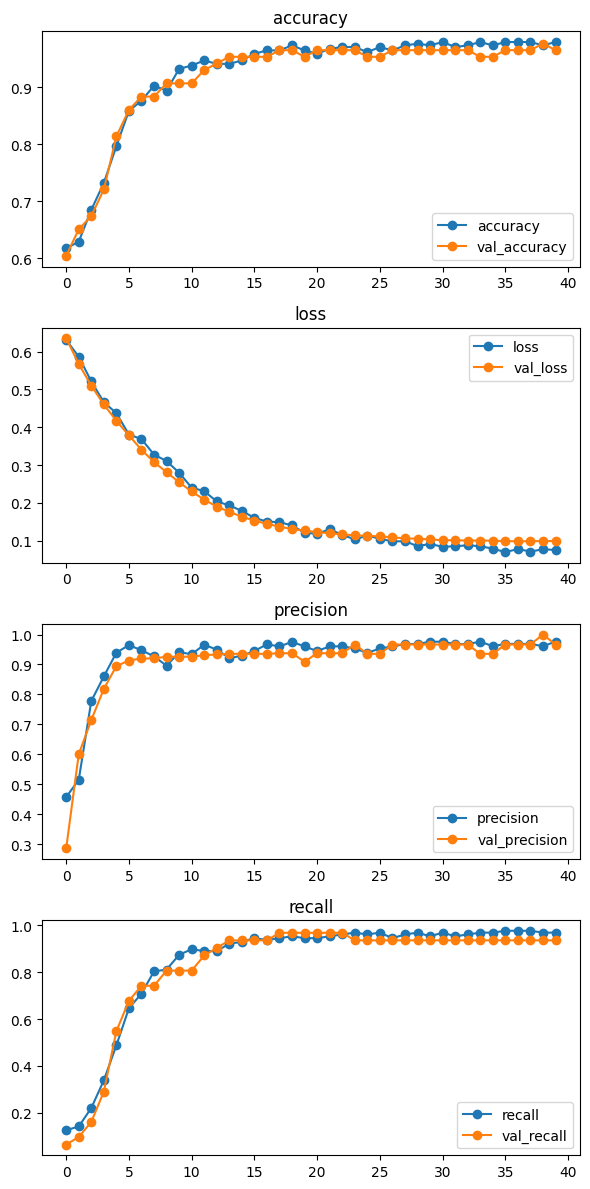

In [14]:
# plot learning history
plot_history(history);

In [15]:
# make predictions
y_pred_test = clf_model.predict(X_test_tf)
y_pred_test[:5]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[0.06989952],
       [0.99877197],
       [0.99150777],
       [0.0058644 ],
       [0.00193684]], dtype=float32)

In [16]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        89
           1       1.00      0.96      0.98        54

    accuracy                           0.99       143
   macro avg       0.99      0.98      0.99       143
weighted avg       0.99      0.99      0.99       143



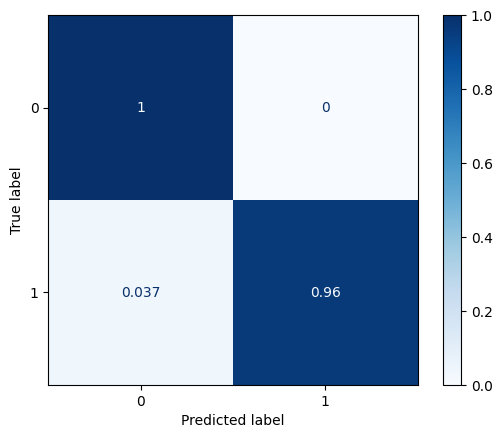

In [17]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');